In [78]:
from google.colab import drive
drive.mount('/content/drive')
!pip install numpy pandas scikit-learn matplotlib
import os

from typing import Any, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_log_error,
    roc_auc_score
)
import matplotlib.pyplot as plt
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
data.drop(columns=["max_floor", "state", 'build_year', "num_room"], inplace=True)
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.columns

Index(['marital_status', 'big_market_raion', 'market_count_1500',
       'leisure_count_3000', 'water_1line', 'railroad_station_walk_km',
       'culture_objects_top_25', '0_17_all', 'product_type', 'total_trans_ct',
       'life_sq', 'school_education_centers_top_20_raion', 'card_category',
       'public_transport_station_min_walk', 'income_category',
       'radiation_raion', 'cafe_sum_1000_min_price_avg', 'ecology', 'gender',
       'floor', 'timestamp', 'education_level', 'full_sq',
       'detention_facility_raion', '__churn', '__price_doc'],
      dtype='object')

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20483 entries, 0 to 20482
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   marital_status                         20483 non-null  int64  
 1   big_market_raion                       20483 non-null  int64  
 2   market_count_1500                      20483 non-null  int64  
 3   leisure_count_3000                     20483 non-null  int64  
 4   water_1line                            20483 non-null  int64  
 5   railroad_station_walk_km               20473 non-null  float64
 6   culture_objects_top_25                 20483 non-null  int64  
 7   0_17_all                               18080 non-null  float64
 8   product_type                           20483 non-null  int64  
 9   total_trans_ct                         20483 non-null  int64  
 10  life_sq                                16290 non-null  float64
 11  sc

In [79]:
objectcol = data.select_dtypes('object').columns
objectcol

Index(['marital_status', 'big_market_raion', 'water_1line',
       'culture_objects_top_25', 'product_type', 'big_road1_1line',
       'card_category', 'income_category', 'thermal_power_plant_raion',
       'radiation_raion', 'ecology', 'gender', 'oil_chemistry_raion',
       'nuclear_reactor_raion', 'railroad_1line', 'timestamp',
       'education_level', 'incineration_raion', 'detention_facility_raion',
       'railroad_terminal_raion'],
      dtype='object')

In [80]:
data.drop(columns=['total_revolving_bal', 'total_ct_chng_q4_q1', 'contacts_count_12_mon', 'build_count_wood', 'credit_limit', 'mkad_km', 'avg_utilization_ratio',
                   'customer_age', 'total_amt_chng_q4_q1', 'total_trans_amt', 'months_inactive_12_mon', 'months_on_book', 'dependent_count', 'avg_open_to_buy',
                   'total_relationship_count', 'build_count_mix'], inplace=True) # потому что коррелируют с целевой переменной мало


In [81]:
data.drop(columns=['trc_count_2000', 'leisure_count_5000',
 'cafe_count_1000_price_1000', 'detention_facility_km',
 'sport_count_2000', 'metro_km_walk', 'office_sqm_5000', 'cafe_sum_1500_min_price_avg'], inplace=True) # потому что коррелируют между собой много


In [82]:
data.replace({"no": 0, "yes": 1}, inplace=True)


<ipython-input-82-856e08651d25>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"no": 0, "yes": 1}, inplace=True)


In [83]:
data.drop(columns=['nuclear_reactor_raion', "railroad_1line", "oil_chemistry_raion",
        'big_road1_1line','thermal_power_plant_raion','incineration_raion','railroad_terminal_raion' ], inplace=True) # соотношение огромное

In [84]:
data.drop(columns=['education_level' ], inplace=True) # соотношение огромное

In [85]:
data.drop(columns=['card_category'], inplace=True) # соотношение огромное

In [86]:
data.drop(columns=['ecology'], inplace=True) # соотношение огромное

In [87]:
data.drop(columns=['timestamp'], inplace=True) # соотношение огромное

In [88]:
data.drop(columns=['0_17_all'], inplace=True) # соотношение огромное

In [89]:
data["income_category"].value_counts()
data.replace({"$120K +": 1, "$60K - $80K": 0.6, "$40K - $60K": 0.4, "$80K - $120K":0.8, "Less than $40K": 0.2, "Unknown":0}, inplace=True)


<ipython-input-89-f21ee06b632d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"$120K +": 1, "$60K - $80K": 0.6, "$40K - $60K": 0.4, "$80K - $120K":0.8, "Less than $40K": 0.2, "Unknown":0}, inplace=True)


In [90]:

#objectcol = data.select_dtypes('object').columns
#objectcol
categorical_columns= ['marital_status', 'product_type', 'gender']
categorical_features = data[categorical_columns]
unprocessed_cat_features = categorical_features.select_dtypes(include=[object]).columns.tolist()
from sklearn.preprocessing import OneHotEncoder
#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(data[unprocessed_cat_features])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(unprocessed_cat_features), index=data.index )
# Concatenate the one-hot encoded dataframe with the original dataframe
data = pd.concat([data, one_hot_df], axis=1)

# Drop the original categorical columns
data = data.drop(unprocessed_cat_features, axis=1)

# Display the resulting dataframe

In [91]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=pd.NA, strategy='mean')

# Преобразуем все числовые столбцы
numeric_columns = data.select_dtypes(include=['number']).columns
transformed_data = imputer.fit_transform(data[numeric_columns])

# Обновляем DataFrame новыми данными
data[numeric_columns] = transformed_data

# Сохраняем обновленный DataFrame обратно в CSV файл (если нужно)

In [92]:
data.to_csv("meowtest.csv")

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20483 entries, 0 to 20482
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   big_market_raion                       20483 non-null  float64
 1   market_count_1500                      20483 non-null  float64
 2   leisure_count_3000                     20483 non-null  float64
 3   water_1line                            20483 non-null  float64
 4   railroad_station_walk_km               20483 non-null  float64
 5   culture_objects_top_25                 20483 non-null  float64
 6   total_trans_ct                         20483 non-null  float64
 7   life_sq                                20483 non-null  float64
 8   school_education_centers_top_20_raion  20483 non-null  float64
 9   public_transport_station_min_walk      20483 non-null  float64
 10  income_category                        20483 non-null  float64
 11  ra

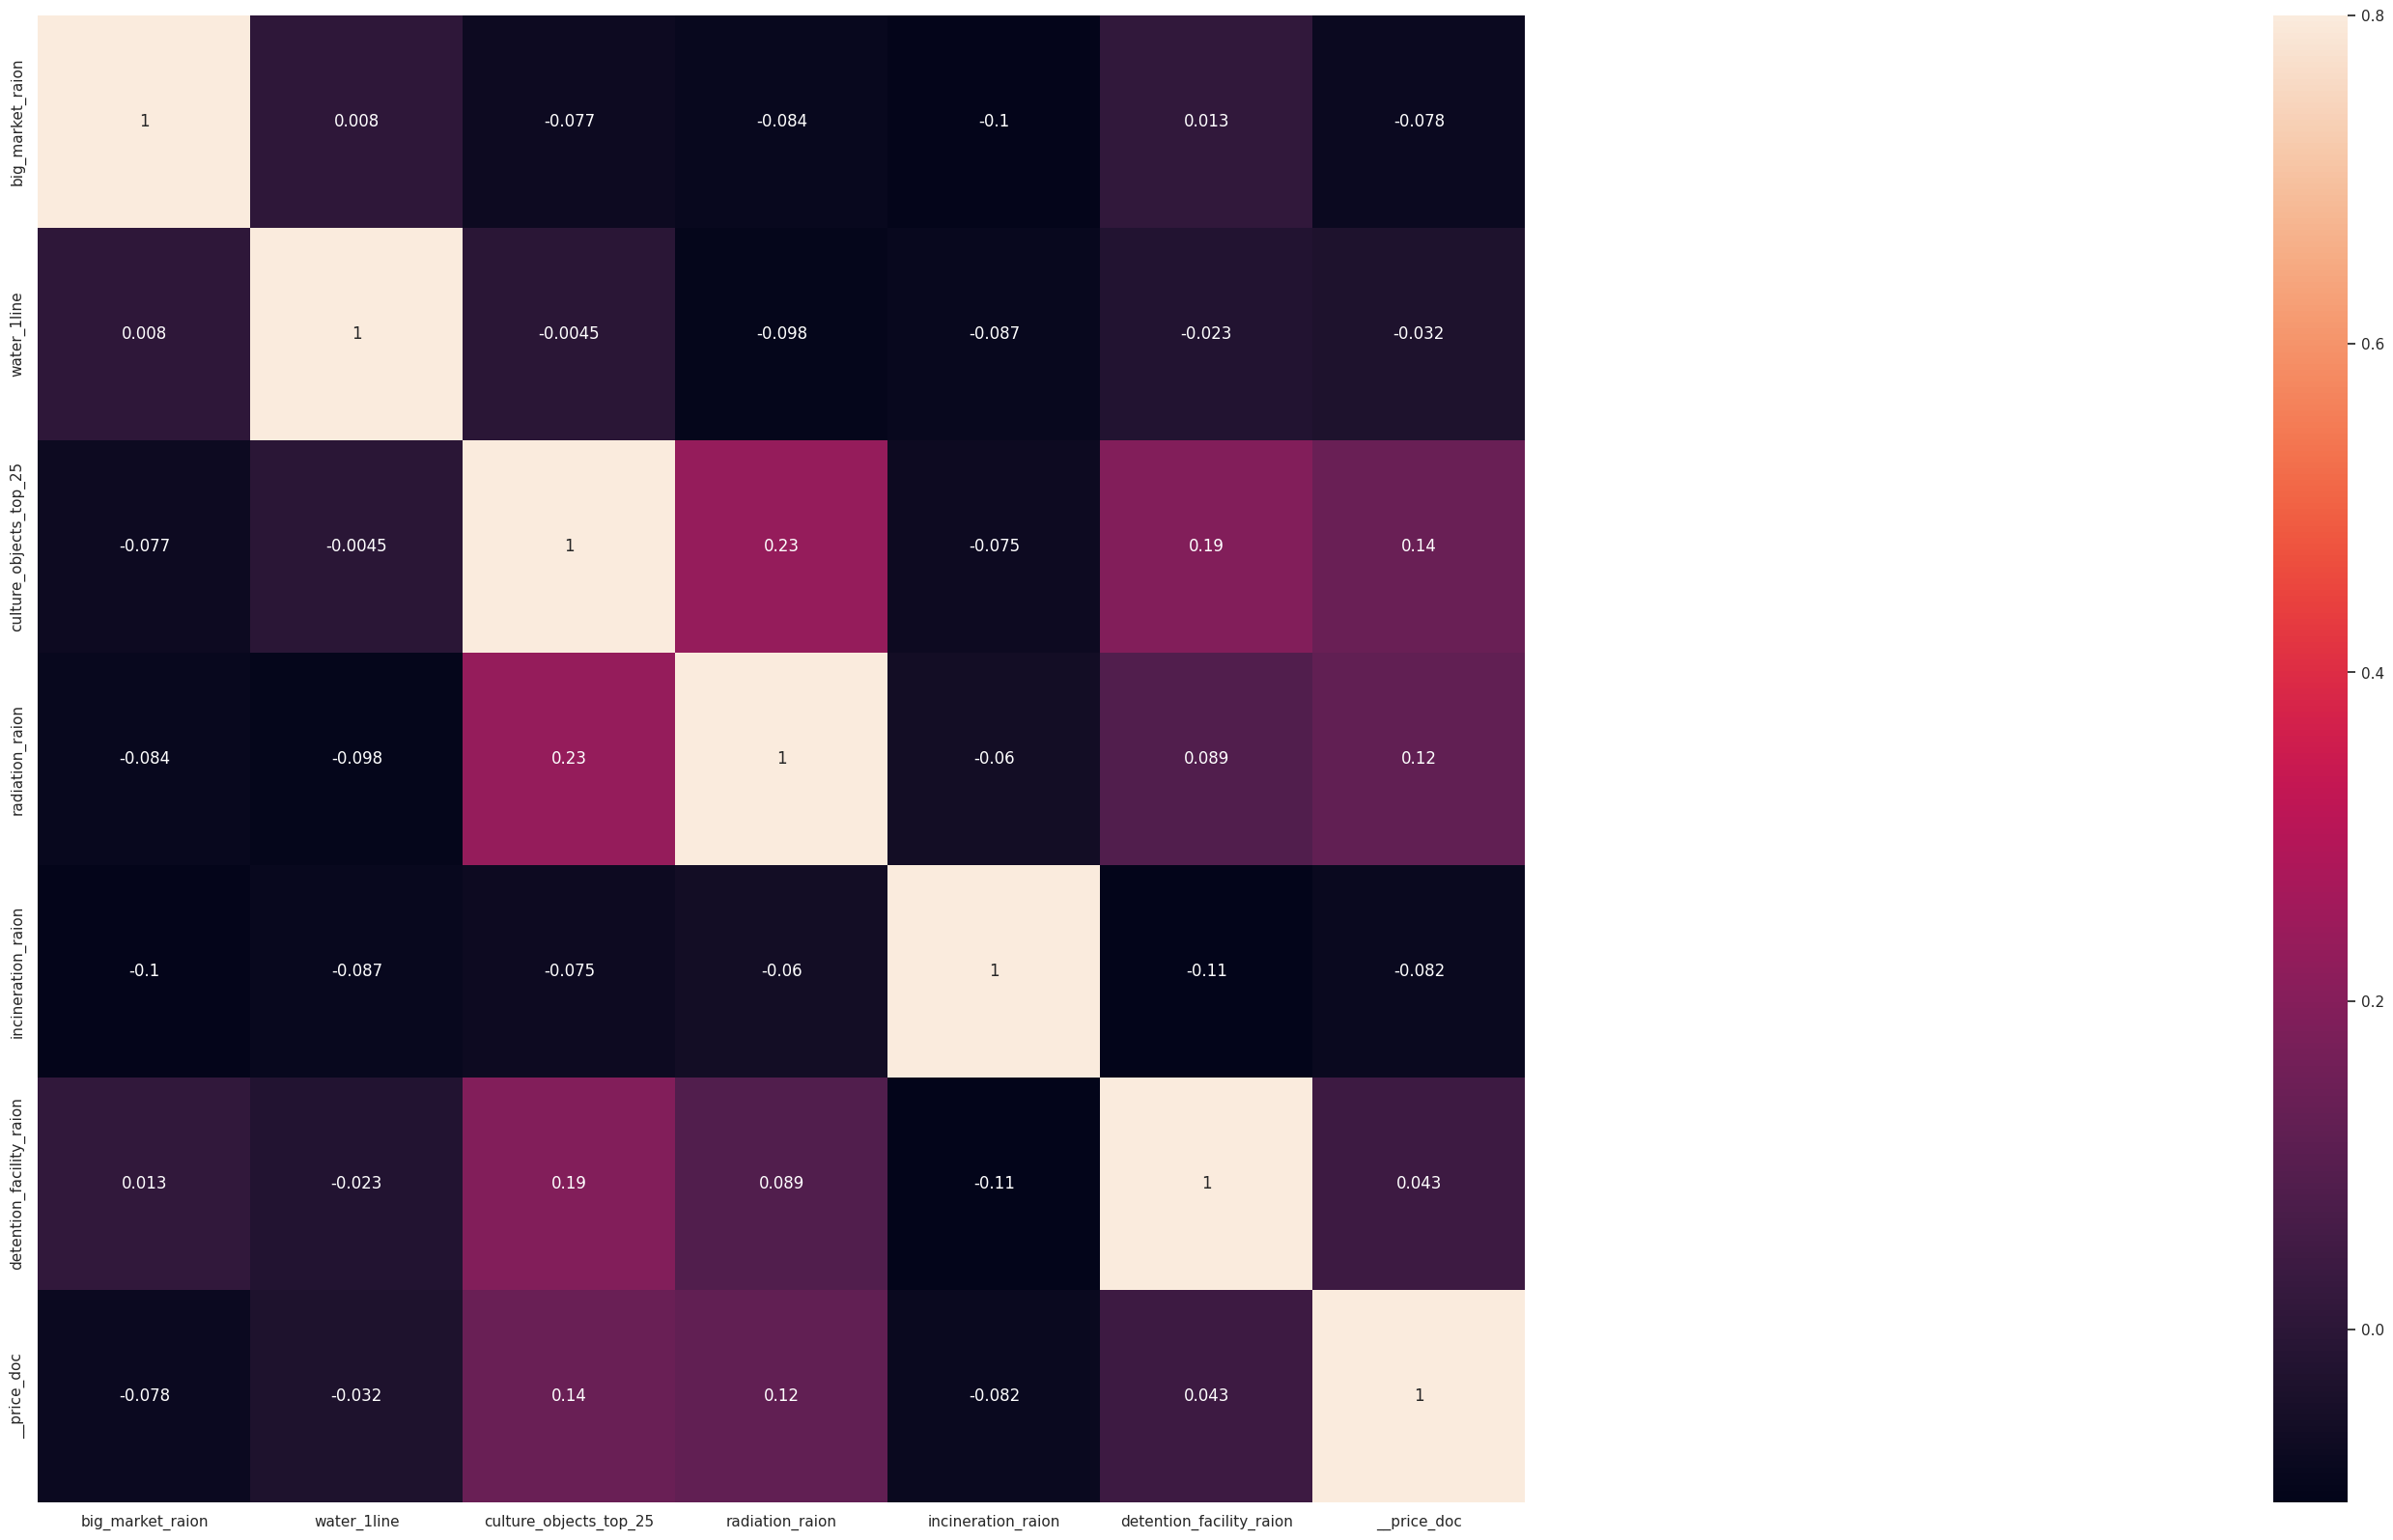

In [ ]:
corrmat = data[['big_market_raion', 'water_1line',
       'culture_objects_top_25',
       'radiation_raion',
        'incineration_raion', 'detention_facility_raion',  "__price_doc"]].corr()
f, ax = plt.subplots(figsize=(200, 20))
sns.heatmap(corrmat, vmax=.8, square=True, annot = True);

In [ ]:
#data.replace({"Single": 0, "Married": 1}, inplace=True)
#data.replace({"OwnerOccupier": 0, "Investment": 1}, inplace=True)


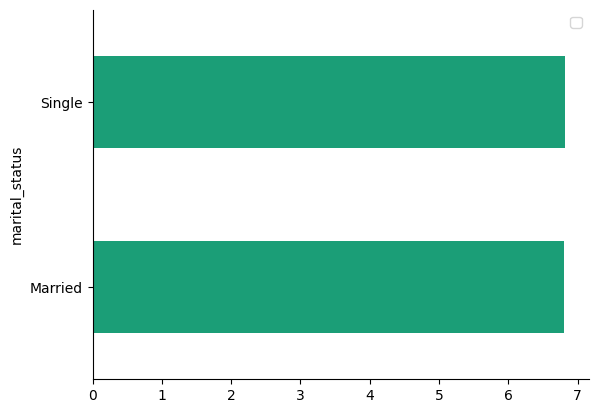

In [8]:
# @title marital_status

from matplotlib import pyplot as plt
import seaborn as sns
numerical_columns = ['marital_status', '__price_doc']
num_features = data[numerical_columns]
num_features.groupby('marital_status').mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

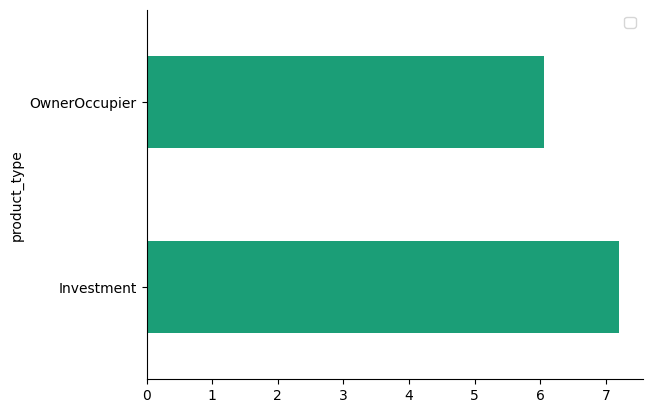

In [9]:
# @title product_type

from matplotlib import pyplot as plt
import seaborn as sns
numerical_columns = ['product_type', '__price_doc']
num_features = data[numerical_columns]
num_features.groupby('product_type').mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

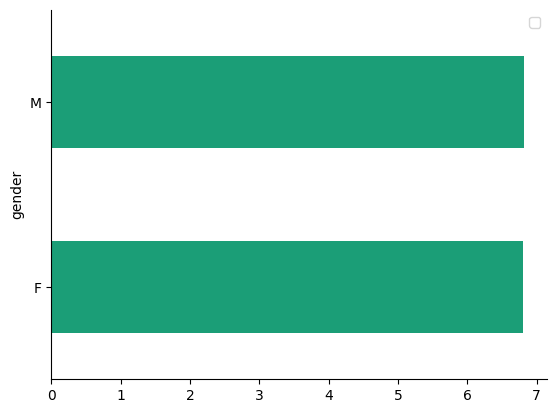

In [10]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
numerical_columns = ['gender', '__price_doc']
num_features = data[numerical_columns]
num_features.groupby('gender').mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

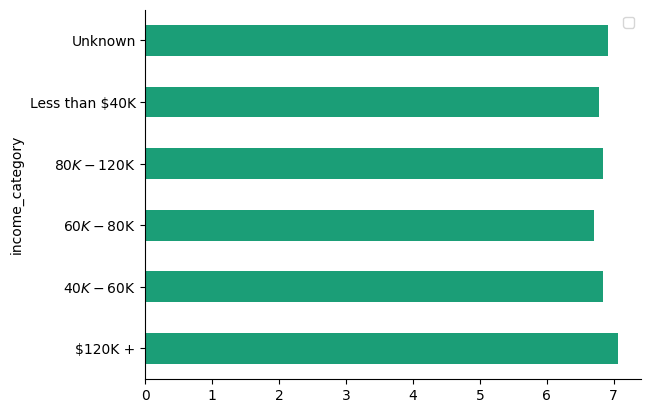

In [11]:
# @title income_category

from matplotlib import pyplot as plt
import seaborn as sns
numerical_columns = ['income_category', '__price_doc']
num_features = data[numerical_columns]
num_features.groupby('income_category').mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)